* Imports

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score , confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold, cross_val_predict

#### Data Loading and Understanding

In [3]:
df = pd.read_csv("Telco-Customer-Churn-1.csv")

In [4]:
df.shape

(7043, 21)

In [5]:
df.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
4964,3943-KDREE,Female,0,No,No,26,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,1834.95,Yes
3538,9028-LIHRP,Male,0,Yes,Yes,71,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),100.20,7209,No
5122,4353-HYOJD,Female,0,Yes,Yes,27,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,No,Mailed check,49.85,1336.15,No
4236,2542-HYGIQ,Female,0,No,No,1,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),19.95,19.95,No
4727,3154-HMWUU,Male,0,Yes,No,60,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),20.50,1198.8,No


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
# dropping customerID column as this is not required for modelling
df = df.drop(columns=["customerID"])

In [8]:
df.duplicated().sum()

22

In [9]:
df = df.drop_duplicates(keep='first')


In [10]:
df.duplicated().sum()

0

In [11]:
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [12]:
# df["TotalCharges"] = df["TotalCharges"].astype(float)

In [13]:
len(df[df["TotalCharges"]==" "])

11

In [14]:
df['TotalCharges'] = df['TotalCharges'].str.strip()
df['TotalCharges'] = df['TotalCharges'].replace("" , np.nan) # because empty  string cannot be cast to float
df['TotalCharges'] = df['TotalCharges'].astype(float)


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7021 non-null   object 
 1   SeniorCitizen     7021 non-null   int64  
 2   Partner           7021 non-null   object 
 3   Dependents        7021 non-null   object 
 4   tenure            7021 non-null   int64  
 5   PhoneService      7021 non-null   object 
 6   MultipleLines     7021 non-null   object 
 7   InternetService   7021 non-null   object 
 8   OnlineSecurity    7021 non-null   object 
 9   OnlineBackup      7021 non-null   object 
 10  DeviceProtection  7021 non-null   object 
 11  TechSupport       7021 non-null   object 
 12  StreamingTV       7021 non-null   object 
 13  StreamingMovies   7021 non-null   object 
 14  Contract          7021 non-null   object 
 15  PaperlessBilling  7021 non-null   object 
 16  PaymentMethod     7021 non-null   object 
 17  

In [16]:
# checking the class distribution of target column
print(df["Churn"].value_counts())

Churn
No     5164
Yes    1857
Name: count, dtype: int64


The churn dataset is moderately imbalanced, with roughly one-quarter of customers churning. Because missing churners is costly for the business, I focused on recall and F1-score rather than accuracy.

## Insights

1. CustomerID was removed as it is an identifier and does not contribute to predictive modeling.

2. The TotalCharges column contained invalid empty string values, which were converted to numeric after proper cleaning.

3. 22 duplicate records were identified and removed to maintain data integrity.

4. Class imbalance was observed in the target variable (Churn), indicating the need for appropriate evaluation metrics beyond accuracy.


### EDA - exploratory data analysis 


#### Univariate Analysis

In [17]:
### NUMERICAL FEATURE ANALYSIS 

numerical_features = df.select_dtypes(['int64','float']).columns.tolist()
numerical_features 

['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [18]:
numerical_features.remove('SeniorCitizen')
numerical_features


['tenure', 'MonthlyCharges', 'TotalCharges']

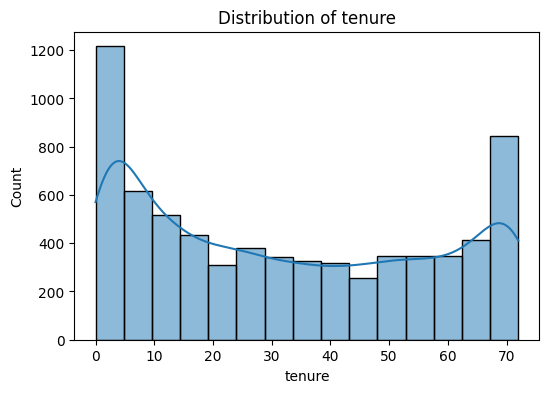

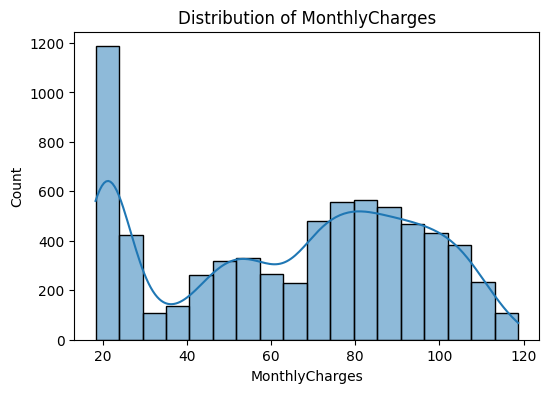

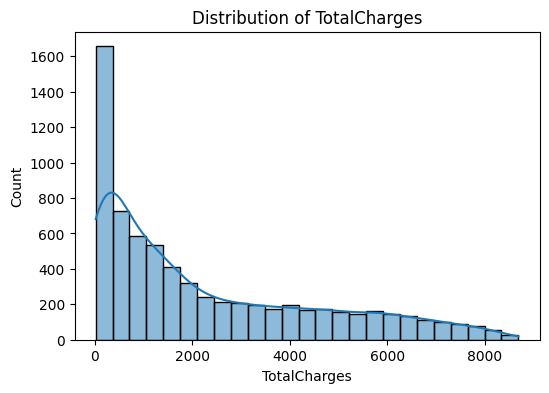

In [19]:

for num_feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.histplot(df[num_feature],kde=True)
    plt.title(f"Distribution of {num_feature}")
    plt.show()


##### Boxplot for numerical features 

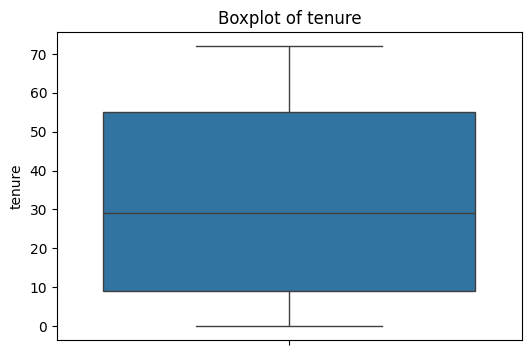

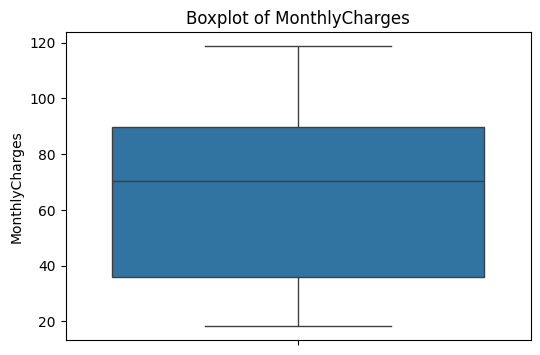

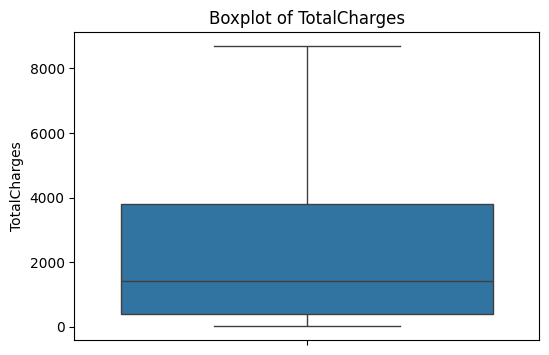

In [20]:
for num_feature in numerical_features:
    plt.figure(figsize=(6,4))
    sns.boxplot(df[num_feature])
    plt.title(f"Boxplot of {num_feature}")
    plt.show()

##### Heatmap For Numerical Features -> To Detect multicollinearity

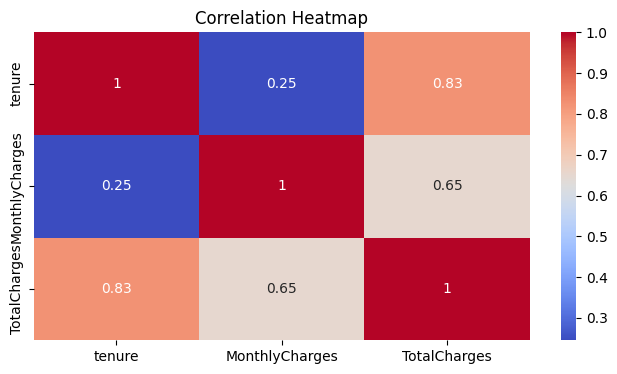

In [21]:
# correlation matrix - heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df[["tenure", "MonthlyCharges", "TotalCharges"]].corr() , annot = True , cmap = "coolwarm")
plt.title("Correlation Heatmap")
plt.show()


##### Insights ->
1. Tenure and TotalCharges are highly correlated (0.83) .

2. No extreme statistical outliers are observed in 'tenure' , 'MonthlyCharges' , 'TotalCharges' .

3. Tenure shows a U-shaped distribution with peaks at low and high tenure , indicating early and long-term churners .

4. MonthlyCharges exhibits a bimodal distribution (two peaks),one paying low charges and another paying high charges.

5. TotalCharges shows a strong right-skewed distribution,
    which is expected as it represents cumulative customer spending that increases with tenure.  

##### Categorical Feature Analysis

In [22]:
categorical_features = df.select_dtypes(include="object").columns.to_list()
categorical_features = ["SeniorCitizen"] + categorical_features 
categorical_features.remove("Churn")
categorical_features


['SeniorCitizen',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

In [23]:
for col in categorical_features:
    print(col, df[col].nunique())

SeniorCitizen 2
gender 2
Partner 2
Dependents 2
PhoneService 2
MultipleLines 3
InternetService 3
OnlineSecurity 3
OnlineBackup 3
DeviceProtection 3
TechSupport 3
StreamingTV 3
StreamingMovies 3
Contract 3
PaperlessBilling 2
PaymentMethod 4


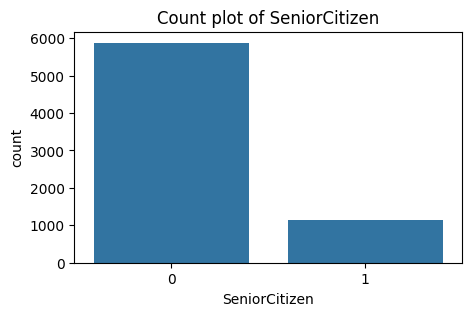

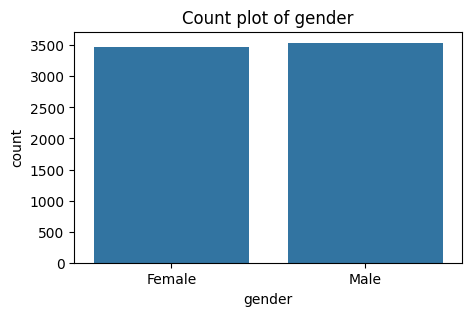

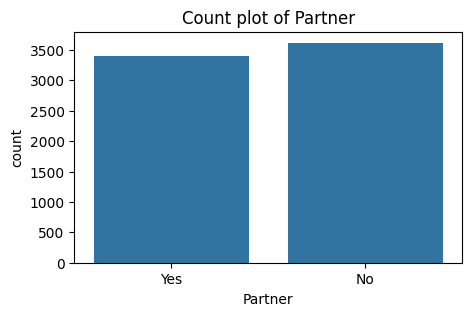

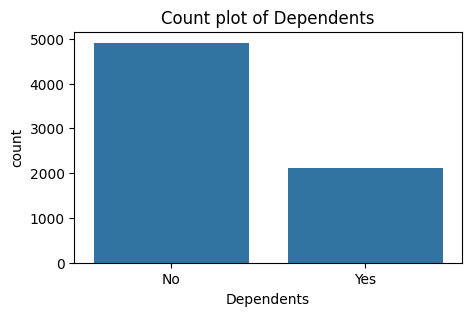

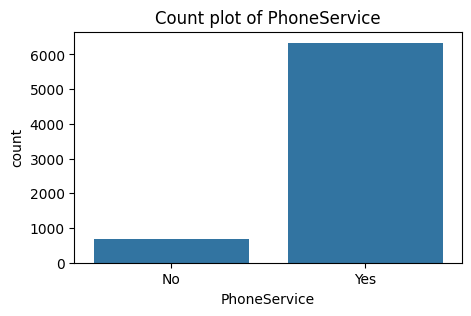

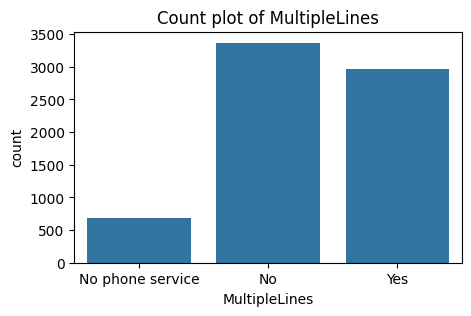

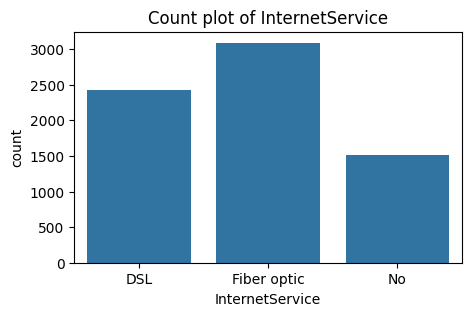

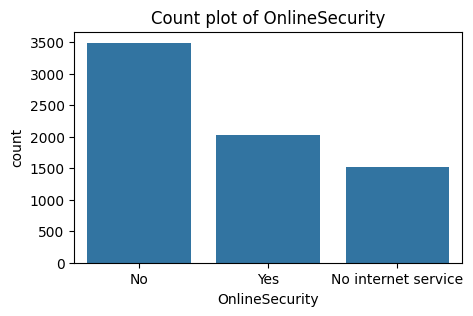

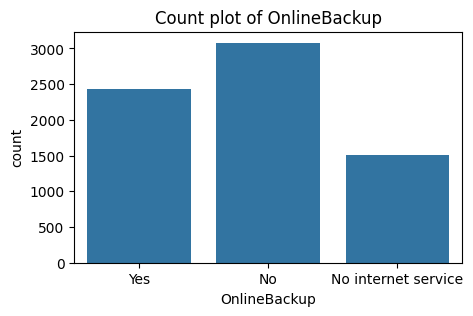

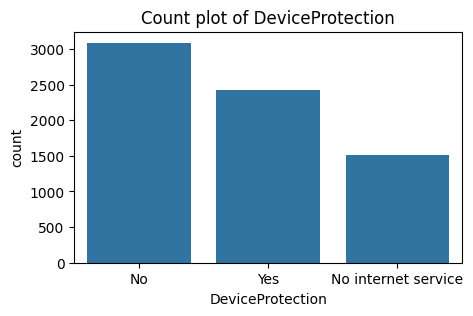

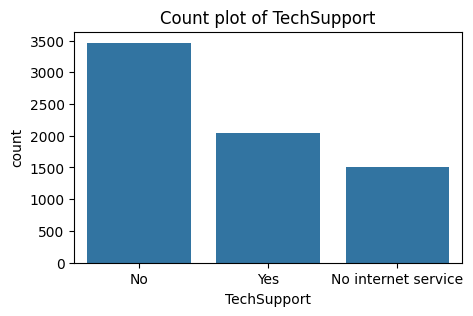

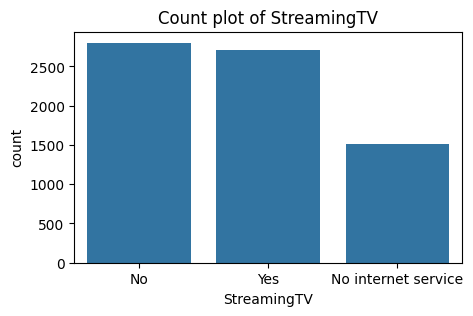

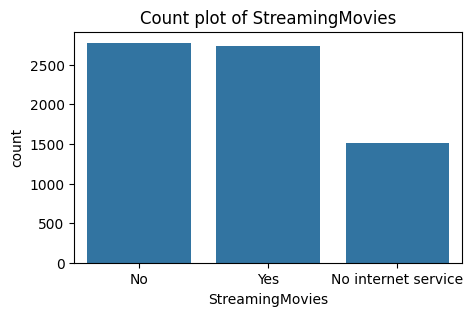

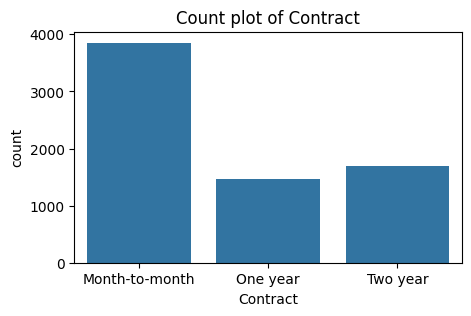

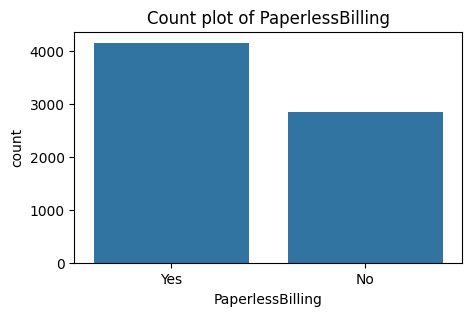

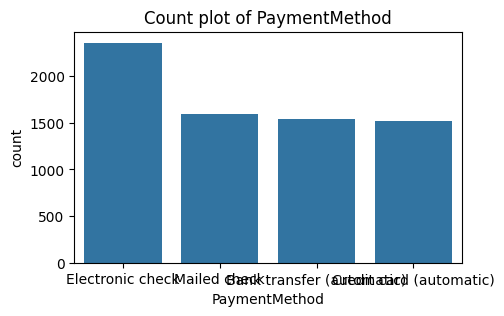

In [24]:
for col in categorical_features:
    plt.figure(figsize=(5,3))
    sns.countplot(x = df[col])
    plt.title(f"Count plot of {col}") 
    plt.show()

##### Insights ->
1. There is a Significant imbalance in SeniorCitizen , indicating most customers are non-senior citizens .
2. PhoneService is highly imbalanced , with most customers subscriebd to phone services .
3. Most customers are on month-month contracts incomparison to one-year and two-year contracts .

#### Bivariate Analysis

Churn vs Numerical_Features ->

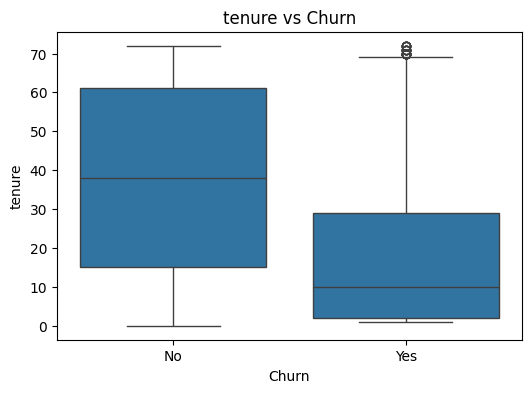

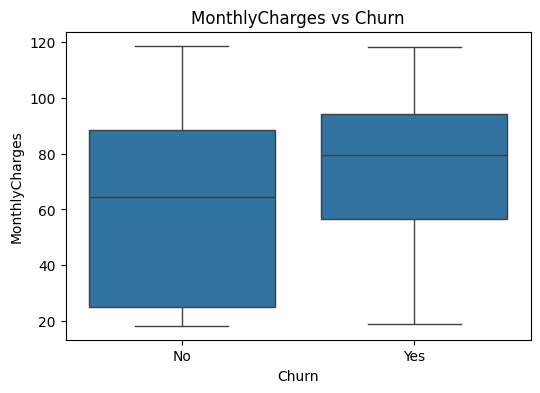

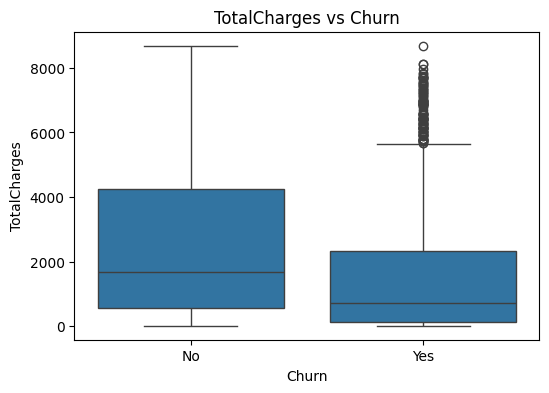

In [25]:
for col in ['tenure','MonthlyCharges','TotalCharges']:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Churn', y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

##### Insights ->
1. Customers who churn have significantly lower tenure as compared to retained customers ,
   indicating a inverse relationship between tenure and churn probablity .
2. Cutomers who churn have tend to have higher MonthlyCharges compared to retained customers,
   indicating increase churn risk with higher monthly charges .
3. Churned customers have significantly lower TotalCharges than retained customers ,
   suggesting long-term customers are less likely to churn .



Churn Vs Categorical_Features ->



In [26]:
for col in categorical_features:
    churn_rate = pd.crosstab(df[col], df['Churn'], normalize='index') * 100
    print(f"\nChurn rate (%) by {col}")
    print(churn_rate.round(2))



Churn rate (%) by SeniorCitizen
Churn             No    Yes
SeniorCitizen              
0              76.50  23.50
1              58.37  41.63

Churn rate (%) by gender
Churn      No    Yes
gender              
Female  73.16  26.84
Male    73.93  26.07

Churn rate (%) by Partner
Churn       No    Yes
Partner              
No       67.17  32.83
Yes      80.34  19.66

Churn rate (%) by Dependents
Churn          No    Yes
Dependents              
No          68.83  31.17
Yes         84.55  15.45

Churn rate (%) by PhoneService
Churn            No    Yes
PhoneService              
No            75.07  24.93
Yes           73.39  26.61

Churn rate (%) by MultipleLines
Churn                No    Yes
MultipleLines                 
No                75.15  24.85
No phone service  75.07  24.93
Yes               71.39  28.61

Churn rate (%) by InternetService
Churn               No    Yes
InternetService              
DSL              81.11  18.89
Fiber optic      58.22  41.78
No               

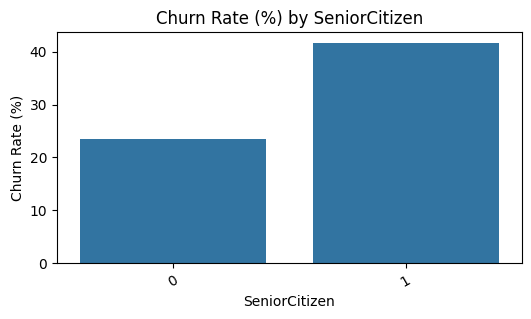

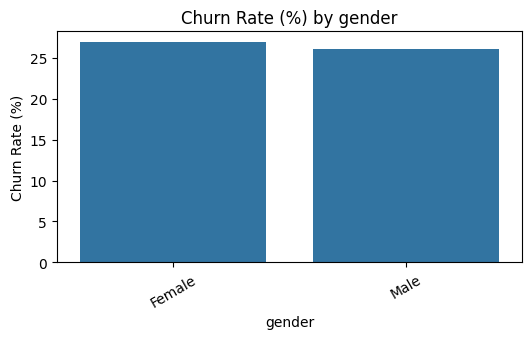

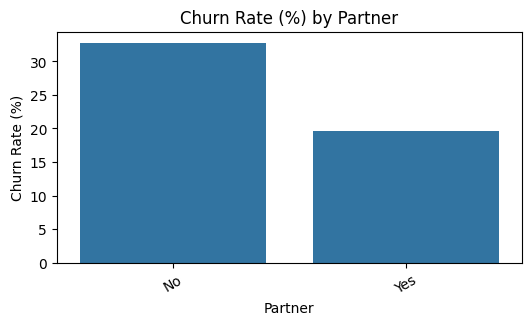

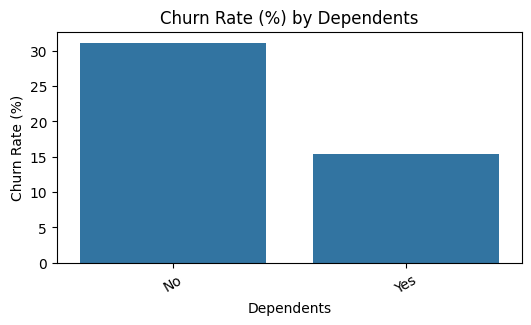

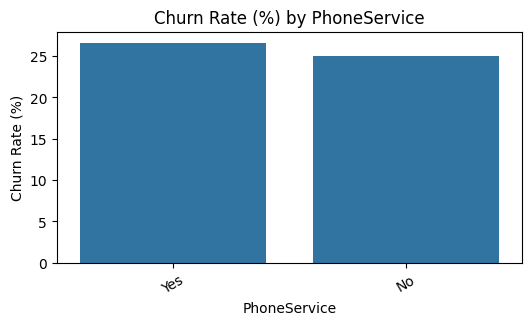

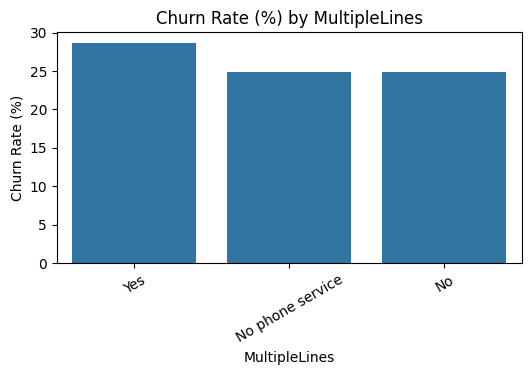

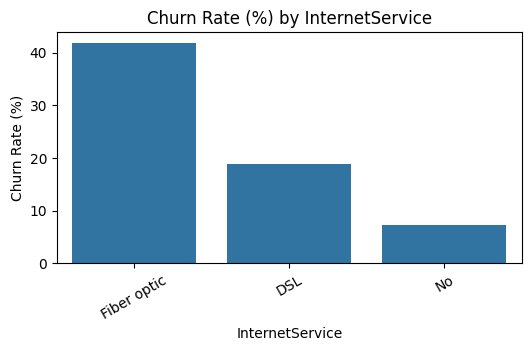

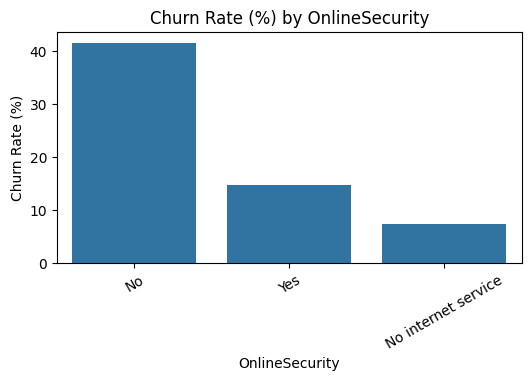

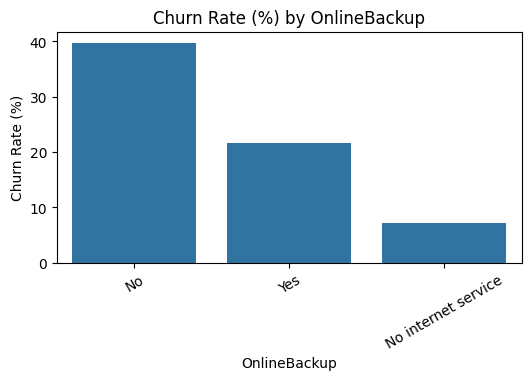

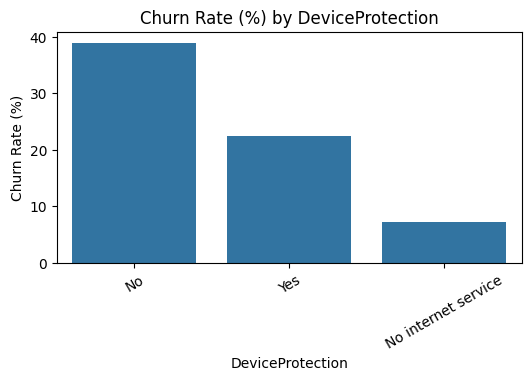

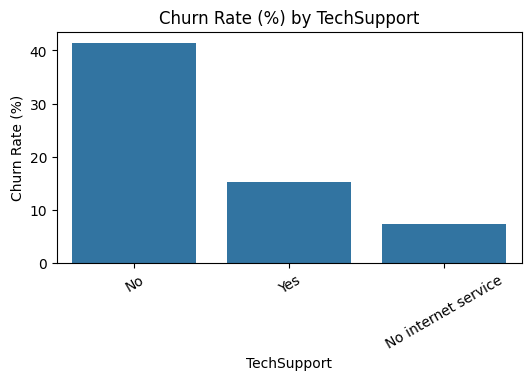

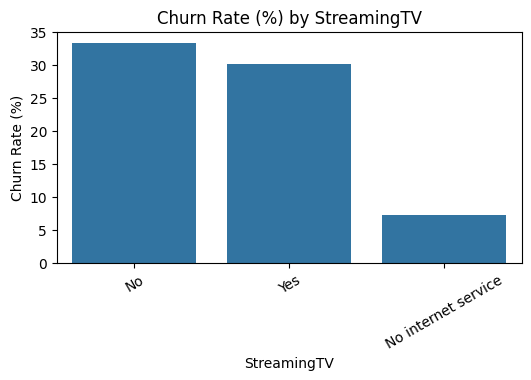

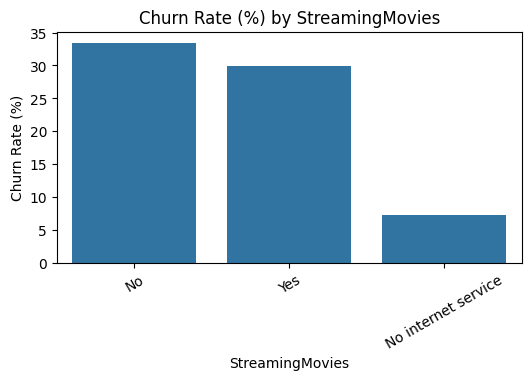

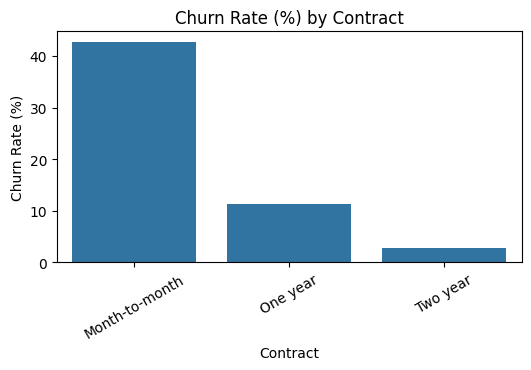

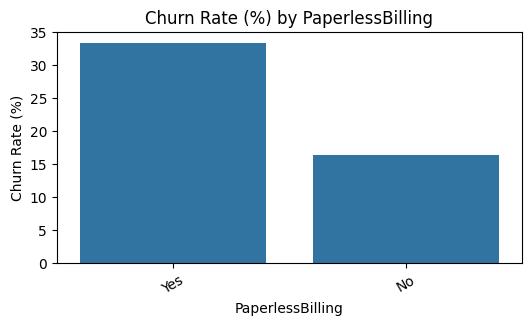

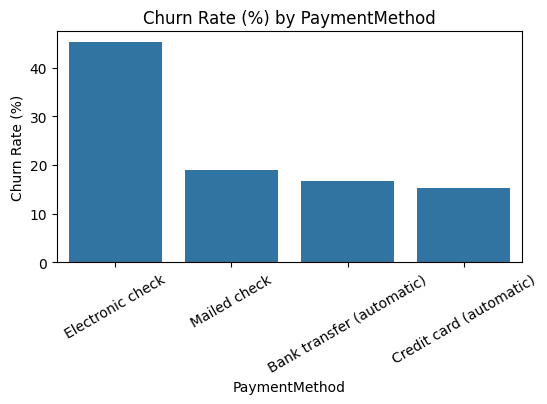

In [27]:
for col in categorical_features:
    churn_rate = (df.groupby(col)['Churn']
                    .apply(lambda x: (x == 'Yes').mean())
                    .sort_values(ascending=False) * 100)

    plt.figure(figsize=(6,3))
    sns.barplot(x=churn_rate.index, y=churn_rate.values)
    plt.title(f"Churn Rate (%) by {col}")
    plt.ylabel("Churn Rate (%)")
    plt.xticks(rotation=30)
    plt.show()


Insights ->
1. Senior citizens churn almost 2X more than non-senior customers.
2. Customers using Fiber optic have significantly higher churn rate than DSL and no-internet customers .
3. Customers without online security have highest churn rate , indicating security add-ons strongly reduce churn risk.
4. Customers without technical support churn more frequently, showing that tech support helps retain customers.
5. Customers on month-to-month contracts have the highest churn rates,
   while long-term contracts significantly reduce churn risk.

#### Data Preprocessing

In [28]:
df.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No


In [29]:
numerical_features 

['tenure', 'MonthlyCharges', 'TotalCharges']

In [30]:
categorical_features

['SeniorCitizen',
 'gender',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Label Encoding of target Column -->

In [31]:
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

In [32]:
df["Churn"].value_counts()

Churn
0    5164
1    1857
Name: count, dtype: int64

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7021 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7021 non-null   object 
 1   SeniorCitizen     7021 non-null   int64  
 2   Partner           7021 non-null   object 
 3   Dependents        7021 non-null   object 
 4   tenure            7021 non-null   int64  
 5   PhoneService      7021 non-null   object 
 6   MultipleLines     7021 non-null   object 
 7   InternetService   7021 non-null   object 
 8   OnlineSecurity    7021 non-null   object 
 9   OnlineBackup      7021 non-null   object 
 10  DeviceProtection  7021 non-null   object 
 11  TechSupport       7021 non-null   object 
 12  StreamingTV       7021 non-null   object 
 13  StreamingMovies   7021 non-null   object 
 14  Contract          7021 non-null   object 
 15  PaperlessBilling  7021 non-null   object 
 16  PaymentMethod     7021 non-null   object 
 17  

Handling nan values of TotalCharges

In [34]:
df["TotalCharges"].isna().sum()

11

In [35]:
df[df["TotalCharges"].isna()][["tenure", "MonthlyCharges", "TotalCharges", "Churn"]]

,tenure,MonthlyCharges,TotalCharges,Churn
488,0,52.55,NaN,0
753,0,20.25,NaN,0
936,0,80.85,NaN,0
1082,0,25.75,NaN,0
1340,0,56.05,NaN,0
3331,0,19.85,NaN,0
3826,0,25.35,NaN,0
4380,0,20.00,NaN,0
5218,0,19.70,NaN,0
6670,0,73.35,NaN,0


Insight->

So these customers whose total_charges are NAN are new customers , so it will logically correct 
to fill their totalcharges with 0 .

In [36]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)
df["TotalCharges"].isna().sum()

0

In [37]:
len(categorical_features)

16

Applying ColumnTransformer ->
1. StandardScaler -> Numerical Columns .
2. OneHotEncoder -> Categorical Columns .

In [40]:
transformer = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False),
         categorical_features)
    ],
    remainder='passthrough'
)


Train Test Split 


In [41]:
X = df.drop("Churn",axis = 1)
y = df["Churn"]

In [42]:


X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

In [43]:
y_train.shape

(5616,)

In [44]:
y_train.value_counts()

Churn
0    4111
1    1505
Name: count, dtype: int64

SMOTE will be used only if needed, as oversampling on one-hot encoded features can create unrealistic samples and may lead to overfitting, especially for tree-based models.

In [45]:


pipe_lr = Pipeline([
    ("preprocess", transformer),
    ("model", LogisticRegression(max_iter=1000, class_weight="balanced"))
])



In [46]:


pipe_rf = Pipeline([
    ("preprocess", transformer),
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=42,
        class_weight="balanced"
    ))
])


In [47]:
import sys
!{sys.executable} -m pip install xgboost



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:


pipe_xgb = Pipeline([
    ("preprocess", transformer),
    ("model", XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        eval_metric="logloss",
        random_state=42
    ))
])


In [49]:


models = {
    "LogisticRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "XGBoost": pipe_xgb
}

for name, pipe in models.items():
    pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)   # precision for class 1
    rec = recall_score(y_test, y_pred)       # recall for class 1

    print(f"\n===== {name} =====")
    print("Accuracy :", round(acc, 4))
    print("Precision:", round(prec, 4))
    print("Recall   :", round(rec, 4))



===== LogisticRegression =====
Accuracy : 0.7388
Precision: 0.4872
Recall   : 0.8097

===== RandomForest =====
Accuracy : 0.7872
Precision: 0.595
Recall   : 0.4716

===== XGBoost =====
Accuracy : 0.7986
Precision: 0.6095
Recall   : 0.5455


Cross-validation results show Logistic Regression achieves the highest churn recall (~0.81), making it the best choice for identifying potential churners. XGBoost provides higher accuracy and precision but lower recall, meaning it misses more churn customers.

#### Hyper-parameter Tuning Of Best model for Recall using GridSearch-CV-->

In [50]:


pipe_lr_1 = Pipeline(steps=[
    ("preprocess", transformer),   # your ColumnTransformer
    ("model", LogisticRegression(solver="saga", max_iter=5000))
])

In [51]:
param_grid = {
    "model__C": [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    "model__penalty": ["l1", "l2"],
    "model__class_weight": [None, "balanced"]
}

In [52]:

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_lr = GridSearchCV(
    estimator=pipe_lr_1,
    param_grid=param_grid,
    scoring="recall",      # <-- optimize for churn recall
    cv=cv,
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best CV Recall:", grid_lr.best_score_)
print("Best Params:", grid_lr.best_params_)
best_lr = grid_lr.best_estimator_


Best CV Recall: 0.8039867109634553
Best Params: {'model__C': 1, 'model__class_weight': 'balanced', 'model__penalty': 'l1'}


In [53]:
base_lr = pipe_lr  # LogisticRegression(class_weight="balanced", max_iter=1000)
best_lr = grid_lr.best_estimator_


In [54]:

scoring = {"recall":"recall", "precision":"precision", "f1":"f1"}

base_scores = cross_validate(base_lr, X_train, y_train, cv=cv, scoring=scoring)
tuned_scores = cross_validate(best_lr, X_train, y_train, cv=cv, scoring=scoring)

print("BASE Recall:", base_scores["test_recall"].mean(), "F1:", base_scores["test_f1"].mean())
print("TUNED Recall:", tuned_scores["test_recall"].mean(), "F1:", tuned_scores["test_f1"].mean())

BASE Recall: 0.8039867109634551 F1: 0.632700054347735
TUNED Recall: 0.8039867109634553 F1: 0.6328739568732304


* Insight->

After applying GridSearchCV for hyperparameter tuning, the model shows only a minor improvement in Recall and F1-score

Since churn detection is highly sensitive to the decision boundary, the next step is to perform threshold tuning on predicted probabilities to further improve recall (catch more churn customers).

Threshold Tuning will be a Trade-Off between precision and Recall .

Default threshold is: 0.5  -->

if probability ≥ 0.5 → predict churn (1)

else → predict non churn (0)

##### * Threshold Tuning ->

In [55]:

## Trying different thresholds 

thresholds = [0.40, 0.45, 0.50]
  
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Generate out-of-fold predicted probabilities
y_prob = cross_val_predict(
    best_lr, X_train, y_train,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

results = []

for thr in thresholds:
    y_pred = (y_prob >= thr).astype(int)

    results.append({
        "threshold": thr,
        "recall": recall_score(y_train, y_pred),
        "f1": f1_score(y_train, y_pred),
        "precision": precision_score(y_train, y_pred),
        
    })

df = pd.DataFrame(results)
print(df.sort_values("recall", ascending=False))

   threshold    recall        f1  precision
0       0.40  0.867110  0.609956   0.470440
1       0.45  0.835880  0.623699   0.497430
2       0.50  0.803987  0.632845   0.521777


Insight (Threshold Tuning)-->

1. At the default threshold 0.50, the model achieves the best F1-score, meaning it gives the best balance between 
Precision and Recall.

2. Reducing the threshold to 0.40 produces the highest Recall, meaning we capture the maximum number of churn customers   (but with more false positives → lower Precision).

3. A threshold around 0.45 acts as a good middle ground, increasing Recall significantly while keeping the F1-score        reasonably stable.


## Testing the Final Model On Test Data

In [56]:
final_thr = 0.45

best_lr.fit(X_train, y_train)

y_test_prob = best_lr.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= final_thr).astype(int)


In [57]:

print("Threshold:", final_thr)
print("Recall:", recall_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))

print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))



Threshold: 0.45
Recall: 0.84375
Precision: 0.4640625
F1: 0.5987903225806451

Confusion Matrix:
 [[710 343]
 [ 55 297]]


#### * Final Conclusion / Final Model Result (Churn Prediction)

1. Final Model - Logistic Regression .

2. Threshold Selected - 
    0.45 (chosen to increase churn recall)

3. Recall - 0.8438 (84.4%) ->

    The model successfully identified most churn customers.

4. F1 Score - 0.5988 (approx 60 %) ->

    Balanced score reflecting the recall–precision tradeoff.

* Saving the Model ->

In [58]:
import joblib

artifact = {
    "model": best_lr,          # tuned model/pipeline
    "threshold": 0.45          # your tuned threshold
}

joblib.dump(artifact, "churn_lr_model.joblib")
print("Saved!")


Saved!
